In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.cluster import DBSCAN
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import metrics
import matplotlib.pyplot as plt
from itertools import product

In [2]:
df = pd.read_csv('..\data\imputed_dataset.csv')
df.head()

name  rating  ranking  year position  height  weight  \
0  Dorial Green-Beckham  0.9997      1.0  2012       WR    78.0   220.0   
1         Mario Edwards  0.9995      2.0  2012       DT    75.0   285.0   
2        D.J. Humphries  0.9979      3.0  2012       OT    77.0   275.0   
3         Shaq Thompson  0.9975      4.0  2012        S    74.0   210.0   
4           Noah Spence  0.9974      5.0  2012      WDE    75.0   235.0   

    latitude   longitude hometown_city  ... latitude_school longitude_school  \
0  37.216678  -93.292037   Springfield  ...       38.935849       -92.333201   
1  33.215039  -97.133052        Denton  ...       30.438169       -84.304403   
2  35.227200  -80.843083     Charlotte  ...       29.649936       -82.348579   
3  38.581572 -121.494400    Sacramento  ...       47.650323      -122.301575   
4  40.266311  -76.886112    Harrisburg  ...       40.001645       -83.019727   

   wins_rolling_2year games_played_rolling_2year  \
0                18.0                       26.0   
1                19.0                       27.0   
2                15.0                       26.0   
3                14.0                       26.0   
4                18.0                       26.0   

   post_season_wins_rolling_2year  point_diff_rolling_2year  \
0                             1.0                     300.0   
1                             2.0                     366.0   
2                             2.0                     178.0   
3                             1.0                    -130.0   
4                             1.0                     363.0   

  win_pct_rolling_2year  distance_miles  side_of_ball  position_group  
0              0.692308      129.726375       offense    pass_catcher  
1              0.703704      776.590432       defense          d_line  
2              0.576923      395.212334       offense          o_line  
3              0.538462      627.908306       defense     d_backfield  
4              0.692308      324.459618       defense          d_line  

[5 rows x 27 columns]

In [3]:
print(f"Percent of all players drafted: {round(len(df[df['is_drafted'] == 1.0]) / len(df) * 100, 2)}%")

Percent of all players drafted: 8.52%


In [4]:
df.columns

Index(['name', 'rating', 'ranking', 'year', 'position', 'height', 'weight',
       'latitude', 'longitude', 'hometown_city', 'state_province',
       'hometown_country', 'stars', 'committed_to', 'athlete_id', 'is_drafted',
       'conference', 'latitude_school', 'longitude_school',
       'wins_rolling_2year', 'games_played_rolling_2year',
       'post_season_wins_rolling_2year', 'point_diff_rolling_2year',
       'win_pct_rolling_2year', 'distance_miles', 'side_of_ball',
       'position_group'],
      dtype='object')

In [19]:
# Define numerical and categorical values
numerical_features = ['rating', 'ranking', 'height', 'weight', 'distance_miles', 'stars', 'wins_rolling_2year', 'games_played_rolling_2year', 'post_season_wins_rolling_2year', 'point_diff_rolling_2year', 'win_pct_rolling_2year']
categorical_features = ['conference', 'side_of_ball', 'position_group', 'position', 'year']
target = ['is_drafted']


In [20]:
# Features and target
X = df[numerical_features+categorical_features]
y = df[target]

In [21]:
def create_pipeline(eps=0.5, min_samples=5, metric='euclidean', alg='auto', leaf_size=30, p=None):
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
        ]
    )

    pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('pca', PCA(n_components=2)),
        ('classifier', DBSCAN(eps=eps, min_samples=min_samples, metric=metric, algorithm=alg, leaf_size=leaf_size, p=p))
    ])
    return pipe, preprocessor

pipe, preprocessor = create_pipeline()

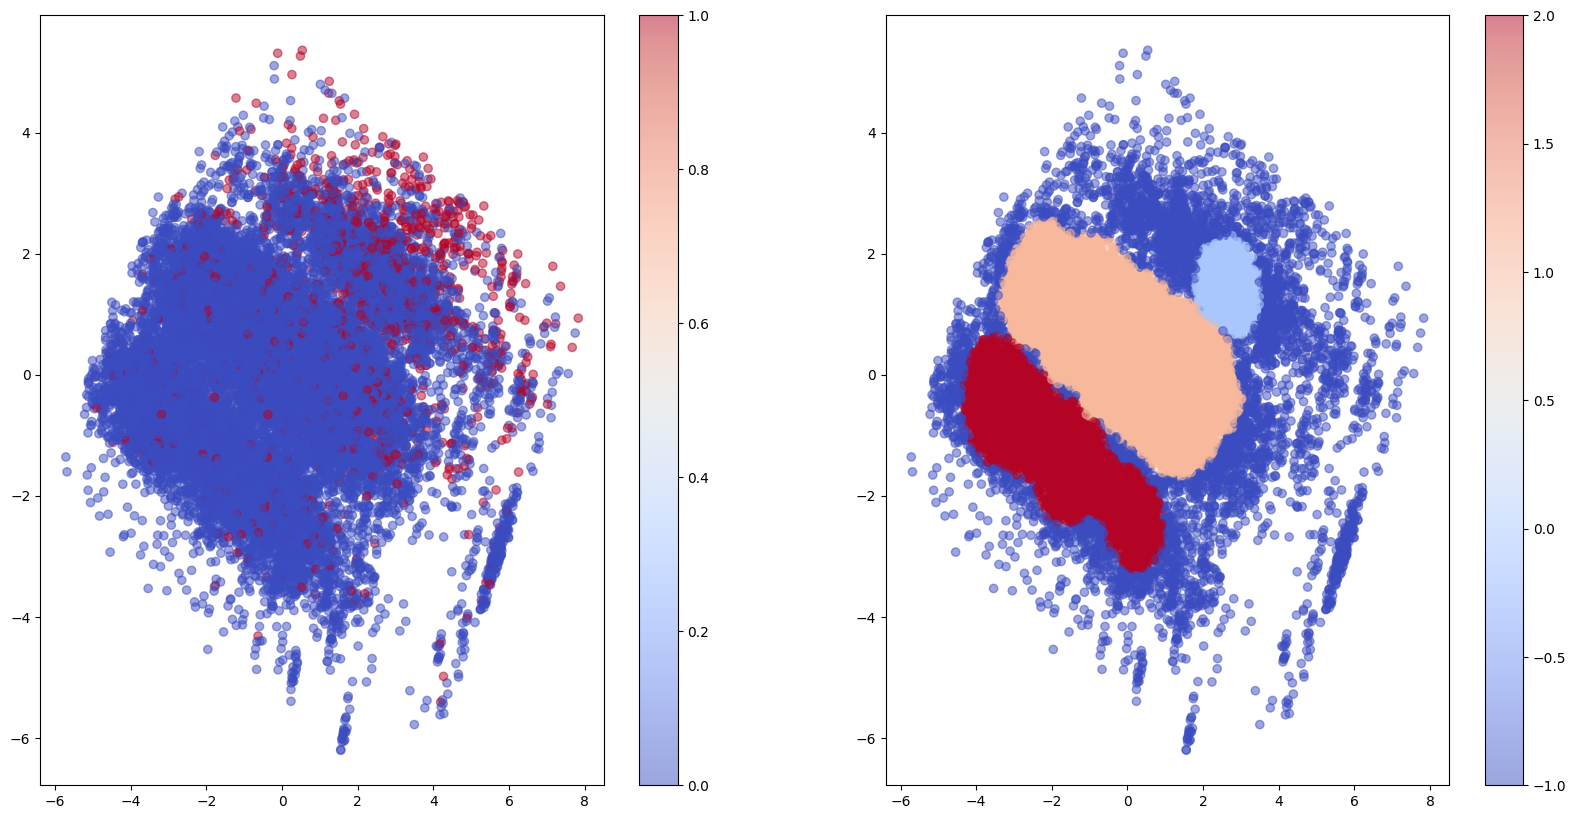

In [48]:
pipe, preprocessor = create_pipeline(eps=.35, min_samples=200)
clusters = pipe.fit_predict(X)
pca_data = pipe.named_steps['pca'].fit_transform(preprocessor.fit_transform(X))
df['cluster'] = clusters
fig, axes = plt.subplots(1,2, figsize=(20,10))

scatter = axes[0].scatter(pca_data[:, 0], pca_data[:, 1], c=df['is_drafted'], cmap='coolwarm', alpha=0.5)
plt.colorbar(scatter, ax=axes[0])

scatter2 = axes[1].scatter(pca_data[:, 0], pca_data[:, 1], c=df['cluster'], cmap='coolwarm', alpha=0.5)
plt.colorbar(scatter2, ax=axes[1])
plt.show()

In [23]:
cluster_summary = df.groupby('cluster')['is_drafted'].agg(['sum', 'count'])
cluster_summary['proportion_drafted'] = cluster_summary['sum'] / cluster_summary['count']
cluster_summary = cluster_summary.sort_values('proportion_drafted', ascending=False)
cluster_summary

sum  count  proportion_drafted
cluster                                  
 0       217.0   1095            0.198174
-1       774.0   5039            0.153602
 1       866.0  12440            0.069614
 2       184.0   5373            0.034245

In [31]:
# Define parameters
eps = [0.2,0.3,0.4,0.5]
min_samples = [20,50,100,200]

all_combos = list(product(eps, min_samples))
num_combos = len(all_combos)


for idx, (ep, min_sample) in enumerate(all_combos):
    pipe, preprocessor = create_pipeline(ep, min_sample)
    clusters = pipe.fit_predict(X)
    pca_data = pipe.named_steps['pca'].fit_transform(preprocessor.fit_transform(X))
    df['cluster'] = clusters

    cluster_summary = df.groupby('cluster')['is_drafted'].agg(['sum', 'count'])
    cluster_summary['proportion_drafted'] = cluster_summary['sum'] / cluster_summary['count']
    cluster_summary = cluster_summary.sort_values('proportion_drafted', ascending=False)
    print(cluster_summary, ep, min_sample)


            sum  count  proportion_drafted
cluster                                   
 3         13.0     36            0.361111
 1         10.0     33            0.303030
 5          6.0     25            0.240000
-1        305.0   1345            0.226766
 2          5.0     39            0.128205
 6          2.0     20            0.100000
 0       1686.0  22276            0.075687
 4         11.0    158            0.069620
 7          1.0     15            0.066667 0.2 20
            sum  count  proportion_drafted
cluster                                   
 0        351.0   1720            0.204070
-1        602.0   3662            0.164391
 1       1083.0  18496            0.058553
 2          3.0     69            0.043478 0.2 50
            sum  count  proportion_drafted
cluster                                   
 2         61.0    394            0.154822
-1       1110.0   9429            0.117722
 3         10.0    100            0.100000
 0        757.0  10809            0.0700

In [32]:
'''
cluster                                   
 0        351.0   1720            0.204070
-1        602.0   3662            0.164391
 1       1083.0  18496            0.058553
 2          3.0     69            0.043478 0.2 50

cluster                                   
 2         61.0    394            0.154822
-1       1110.0   9429            0.117722
 3         10.0    100            0.100000
 0        757.0  10809            0.070034
 1        101.0   3215            0.031415 0.2 100

cluster                                   
 3         16.0     29            0.551724
 1         11.0     63            0.174603
-1         46.0    270            0.170370
 0       1951.0  23388            0.083419
 2         15.0    197            0.076142 0.4 20
 '''

'\ncluster                                   \n 0        351.0   1720            0.204070\n-1        602.0   3662            0.164391\n 1       1083.0  18496            0.058553\n 2          3.0     69            0.043478 0.2 50\n\ncluster                                   \n 2         61.0    394            0.154822\n-1       1110.0   9429            0.117722\n 3         10.0    100            0.100000\n 0        757.0  10809            0.070034\n 1        101.0   3215            0.031415 0.2 100\n\ncluster                                   \n 3         16.0     29            0.551724\n 1         11.0     63            0.174603\n-1         46.0    270            0.170370\n 0       1951.0  23388            0.083419\n 2         15.0    197            0.076142 0.4 20\n '

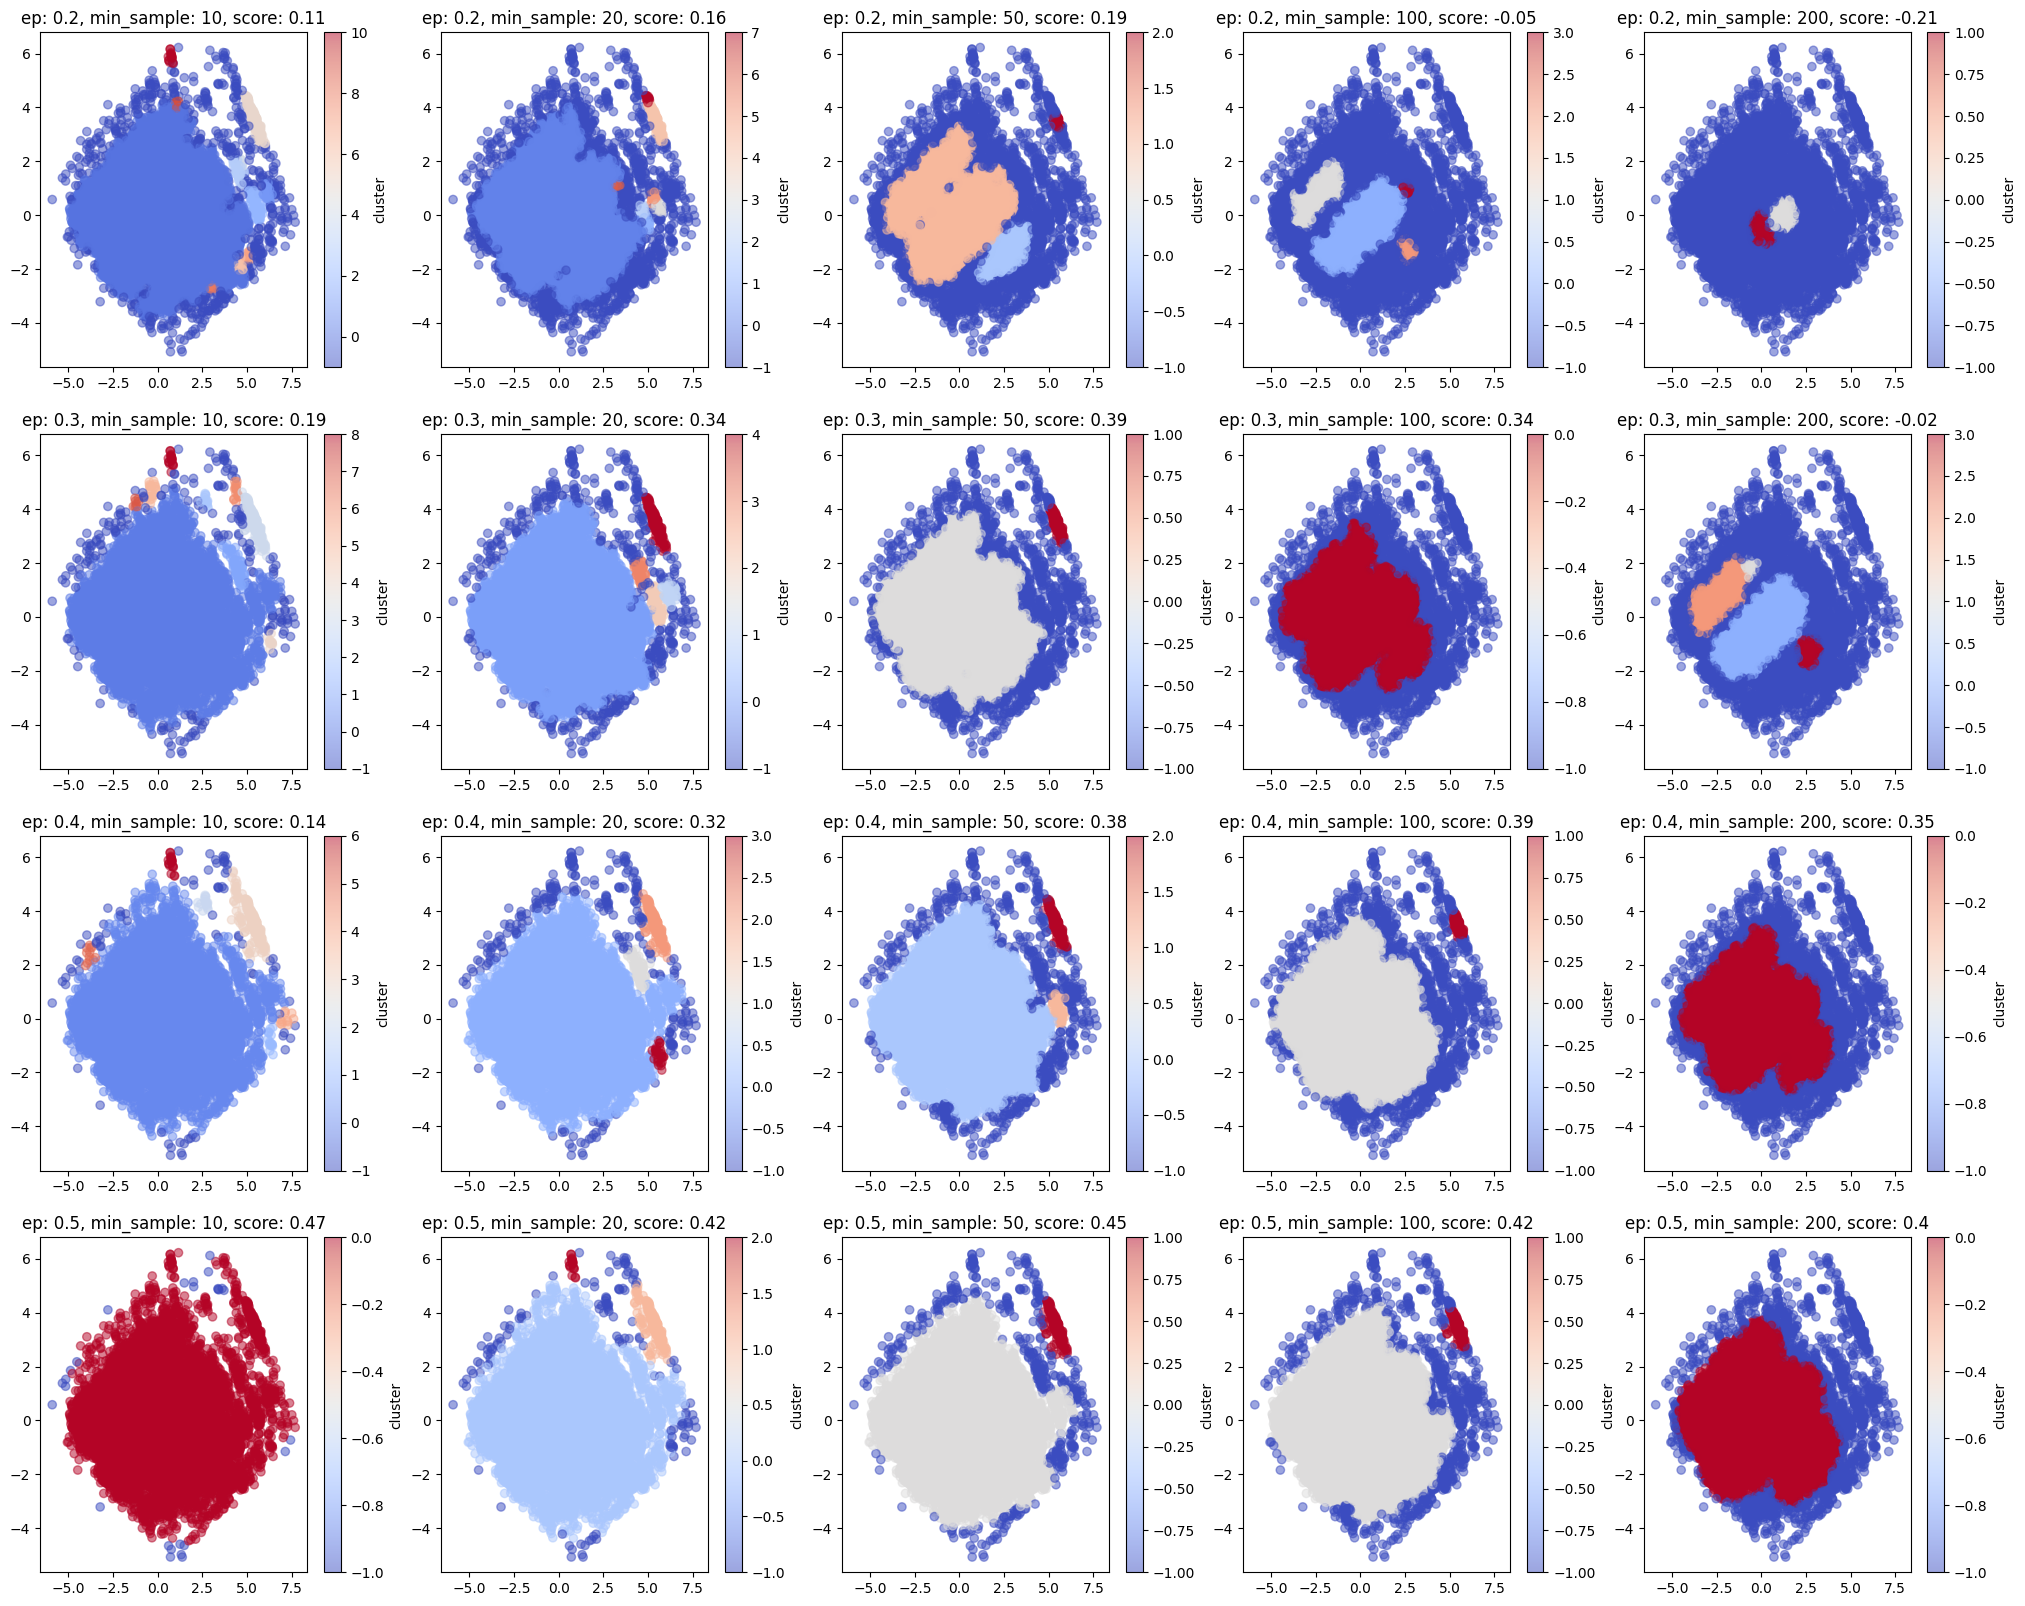

In [33]:
# Define parameters
eps = [0.2,0.3,0.4,0.5]
min_samples = [10,20,50,100,200]

all_combos = list(product(eps, min_samples))
num_combos = len(all_combos)

num_cols = 5
num_rows = (num_combos + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(25, 5 * num_rows))
axes = axes.flatten()

for idx, (ep, min_sample) in enumerate(all_combos):
    ax = axes[idx]  # Get the correct subplot
    pipe, preprocessor = create_pipeline(ep, min_sample)
    clusters = pipe.fit_predict(X)
    pca_data = pipe.named_steps['pca'].fit_transform(preprocessor.fit_transform(X))
    df['cluster'] = clusters

    scatter = ax.scatter(pca_data[:, 0], pca_data[:, 1], c=df['cluster'], cmap='coolwarm', alpha=0.5)
    fig.colorbar(scatter, label='cluster', ax=ax)
    
    score = round(metrics.silhouette_score(pca_data, df['cluster'], metric='euclidean'), 2)
    ax.set_title(f'ep: {ep}, min_sample: {min_sample}, score: {score}')
    #ax.set_xlabel('PCA Component 1')
    #ax.set_ylabel('PCA Component 2')

# Hide any unused subplots if they exist
for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

plt.show()


In [36]:
eps = [0.2,0.3,0.4,0.5]
min_samples = [10,20,50,100,200]

all_combos = list(product(eps, min_samples))
num_combos = len(all_combos)

for idx, (ep, min_sample) in enumerate(all_combos):
    pipe, preprocessor = create_pipeline(ep, min_sample)
    clusters = pipe.fit_predict(X)
    pca_data = pipe.named_steps['pca'].fit_transform(preprocessor.fit_transform(X))
    df['cluster'] = clusters
    score = round(metrics.silhouette_score(pca_data, df['cluster'], metric='euclidean'), 2)
    print(idx, ep, min_sample, score)


0 0.2 10 0.11
1 0.2 20 0.16
2 0.2 50 0.19
3 0.2 100 -0.05
4 0.2 200 -0.21
5 0.3 10 0.19
6 0.3 20 0.34
7 0.3 50 0.39
8 0.3 100 0.34
9 0.3 200 -0.02
10 0.4 10 0.14
11 0.4 20 0.32
12 0.4 50 0.38
13 0.4 100 0.39
14 0.4 200 0.35
15 0.5 10 0.47
16 0.5 20 0.42
17 0.5 50 0.45
18 0.5 100 0.42
19 0.5 200 0.4


In [86]:
eps = [0.2,0.3,0.4,0.5]
min_samples = [10,20,50,100,200]

all_combos = list(product(eps, min_samples))
num_combos = len(all_combos)

for idx, (ep, min_sample) in enumerate(all_combos):
    pipe, preprocessor = create_pipeline(ep, min_sample)
    clusters = pipe.fit_predict(X)
    pca_data = pipe.named_steps['pca'].fit_transform(preprocessor.fit_transform(X))
    df['cluster'] = clusters
    score = round(metrics.calinski_harabasz_score(pca_data, df['cluster']), 2)
    print(idx, ep, min_sample, score)


0 0.2 10 283.89
1 0.2 20 399.18
2 0.2 50 1861.4
3 0.2 100 1434.53
4 0.2 200 322.07
5 0.3 10 248.88
6 0.3 20 594.42
7 0.3 50 1516.35
8 0.3 100 1956.9
9 0.3 200 2082.25
10 0.4 10 297.07
11 0.4 20 573.88
12 0.4 50 959.32
13 0.4 100 1609.91
14 0.4 200 2081.55
15 0.5 10 4.73
16 0.5 20 610.69
17 0.5 50 1147.72
18 0.5 100 1467.65
19 0.5 200 2547.09


In [62]:
preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
        ]
    )

tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(preprocessor.fit_transform(X))

KeyboardInterrupt: 

In [75]:
max_score = 0
max_vals = []

In [81]:
max_vals #3.5, 25 -> 8281

[3.5, 25]

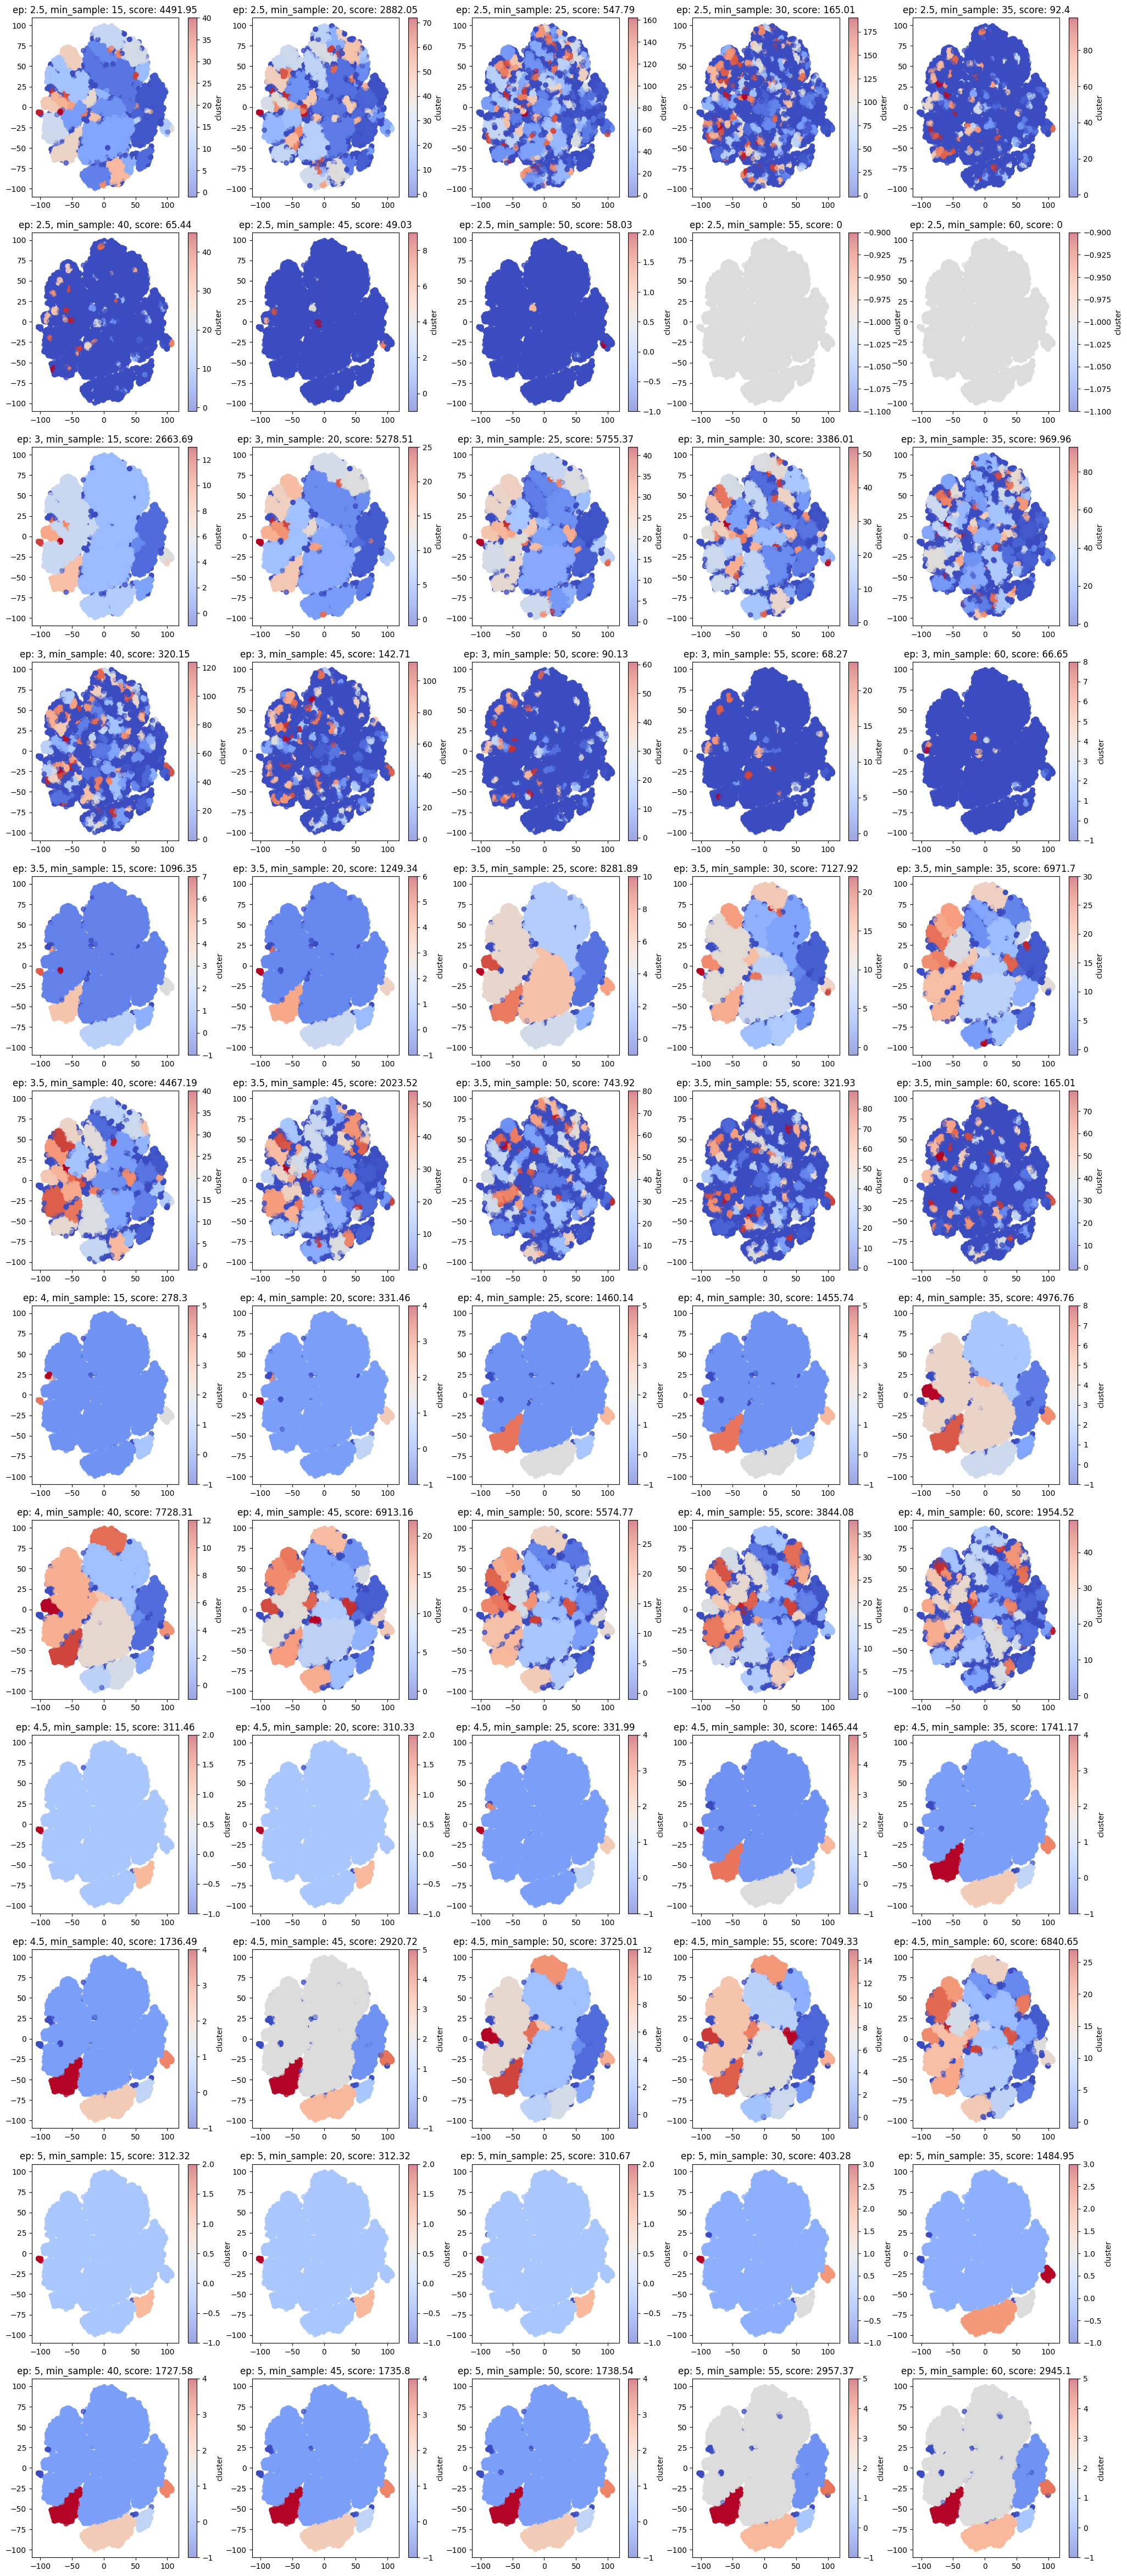

In [82]:
# Define parameters
eps = [2.5,3,3.5,4,4.5,5]
min_samples = [15,20,25,30,35,40,45,50,55,60]

all_combos = list(product(eps, min_samples))
num_combos = len(all_combos)

num_cols = 5
num_rows = (num_combos + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(25, 5 * num_rows))
axes = axes.flatten()

for idx, (ep, min_sample) in enumerate(all_combos):
    ax = axes[idx]  # Get the correct subplot

    dbscan = DBSCAN(eps=ep, min_samples=min_sample)
    df['cluster'] = dbscan.fit_predict(X_tsne)
    try:
        score = round(metrics.calinski_harabasz_score(X_tsne, df['cluster']), 2)
        if score > max_score:
            max_score = score
            max_vals = [ep, min_sample]
    except Exception as e:
        score = 0

    scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=df['cluster'], cmap='coolwarm', alpha=0.5)
    fig.colorbar(scatter, label='cluster', ax=ax)
    
    ax.set_title(f'ep: {ep}, min_sample: {min_sample}, score: {score}')
    #ax.set_xlabel('PCA Component 1')
    #ax.set_ylabel('PCA Component 2')

# Hide any unused subplots if they exist
for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

plt.show()


In [90]:
max_score_sil = 0
max_vals_sil = []

In [93]:
max_score_sil

np.float32(0.18)

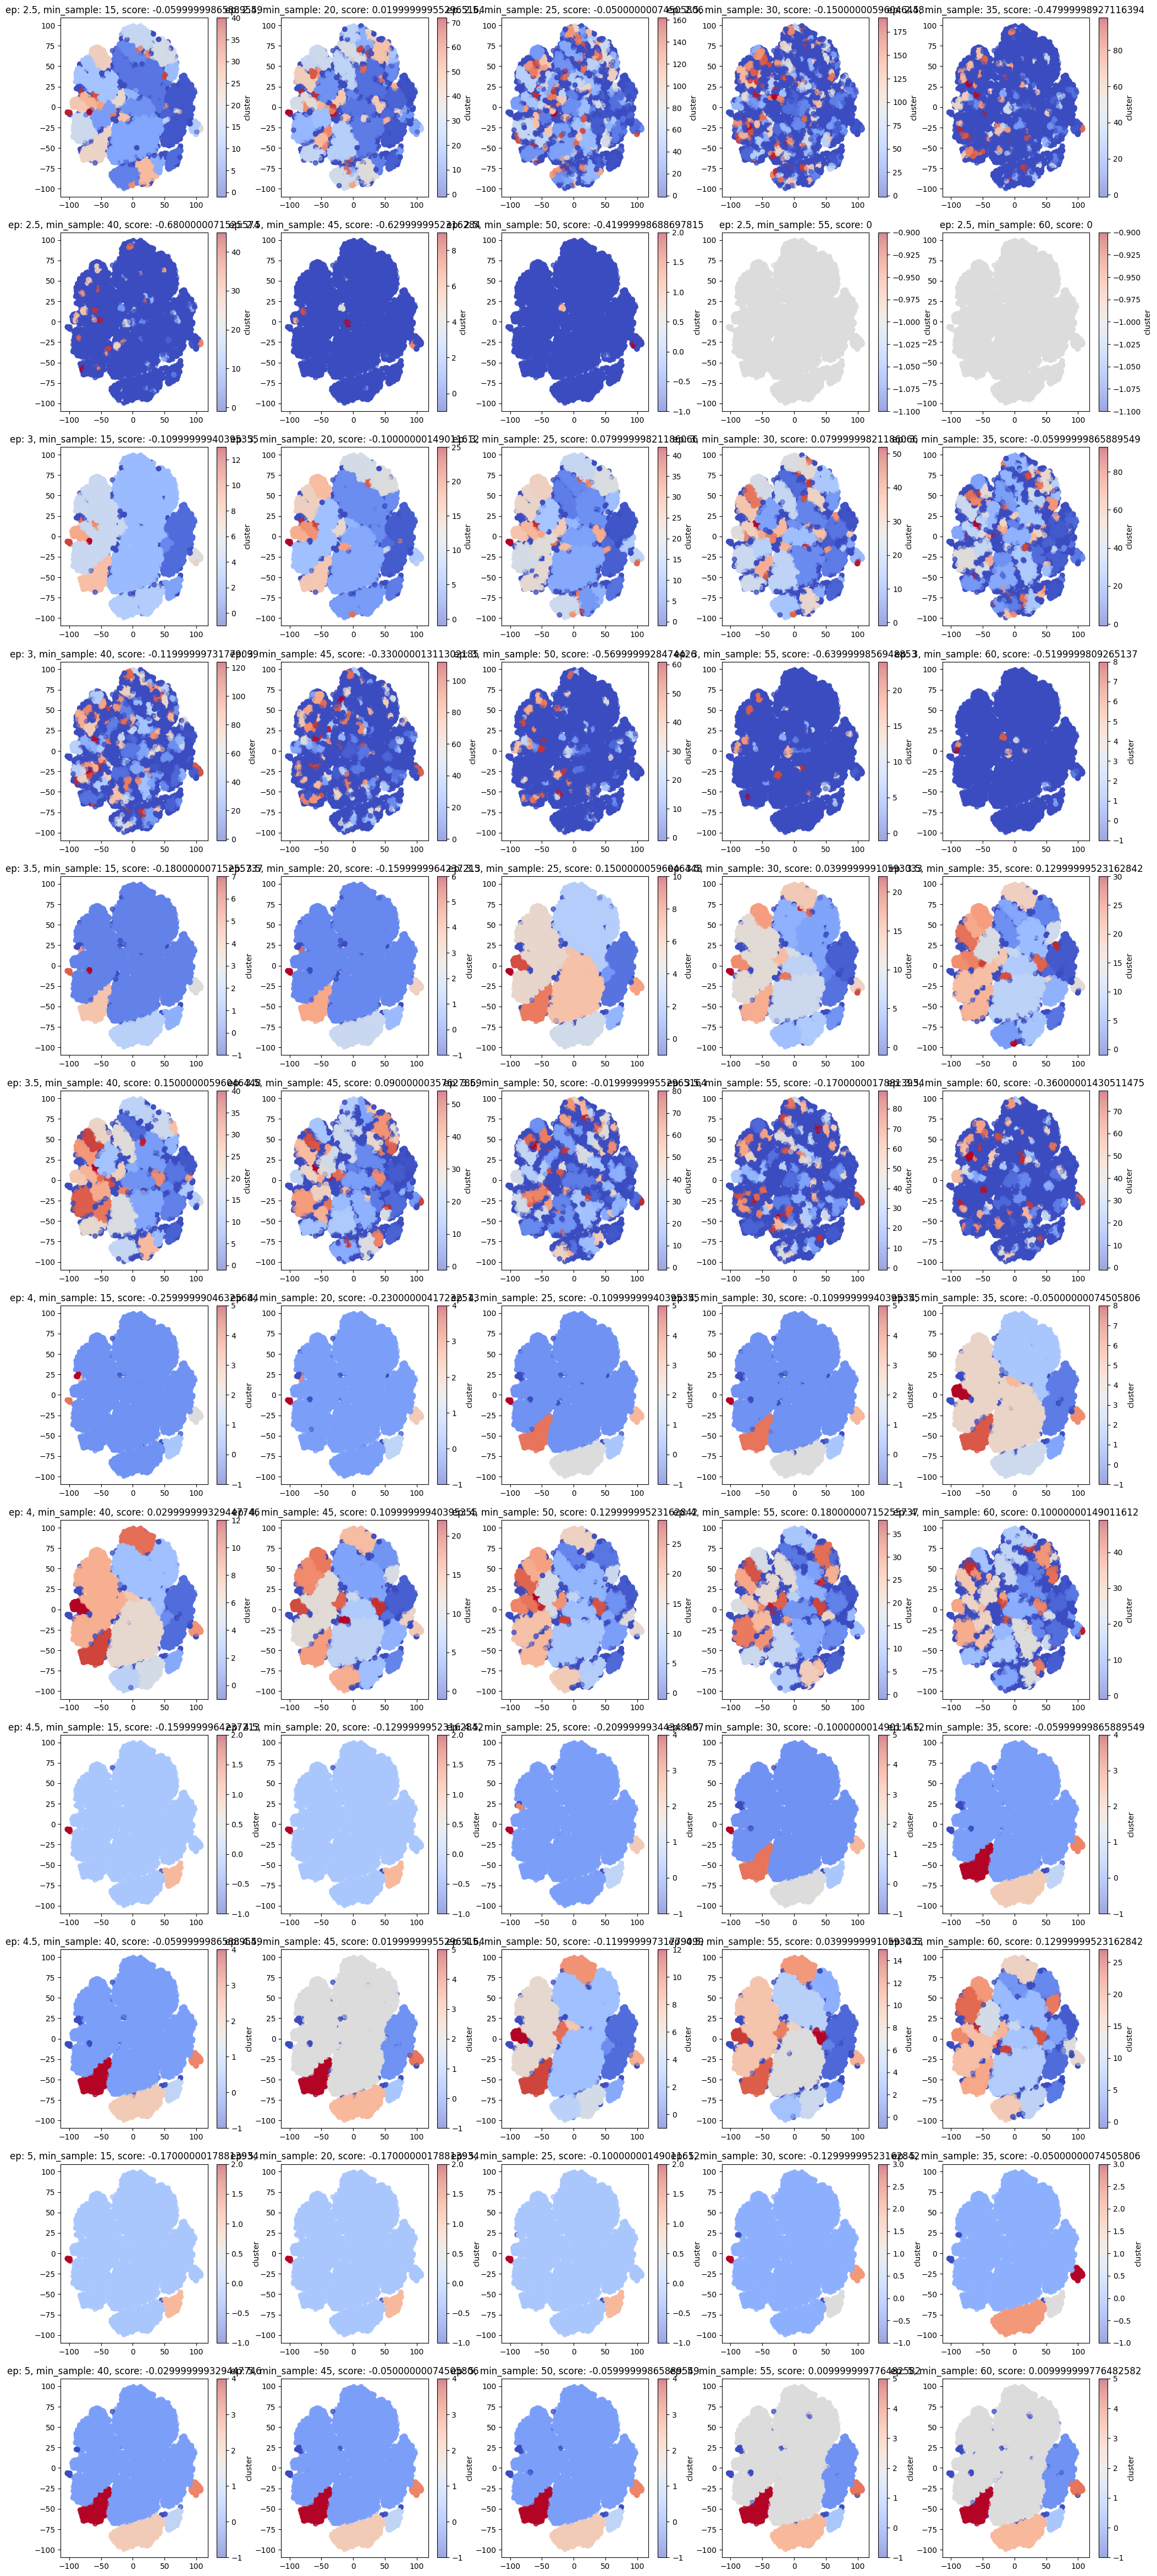

In [91]:
# Define parameters
eps = [2.5,3,3.5,4,4.5,5]
min_samples = [15,20,25,30,35,40,45,50,55,60]

all_combos = list(product(eps, min_samples))
num_combos = len(all_combos)

num_cols = 5
num_rows = (num_combos + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(25, 5 * num_rows))
axes = axes.flatten()

for idx, (ep, min_sample) in enumerate(all_combos):
    ax = axes[idx]  # Get the correct subplot

    dbscan = DBSCAN(eps=ep, min_samples=min_sample)
    df['cluster'] = dbscan.fit_predict(X_tsne)
    try:
        score = round(metrics.silhouette_score(X_tsne, df['cluster'], metric='euclidean'), 2)
        if score > max_score_sil:
            max_score_sil = score
            max_vals_sil = [ep, min_sample]
    except Exception as e:
        score = 0

    scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=df['cluster'], cmap='coolwarm', alpha=0.5)
    fig.colorbar(scatter, label='cluster', ax=ax)
    
    ax.set_title(f'ep: {ep}, min_sample: {min_sample}, score: {score}')
    #ax.set_xlabel('PCA Component 1')
    #ax.set_ylabel('PCA Component 2')

# Hide any unused subplots if they exist
for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

plt.show()
